# Common Vulnerabilities Analysis

Analysis of diff-based vulnerability detection results **restricted to the 582 vulnerability IDs that appear across ALL models**.

This ensures a fair comparison by evaluating all models on the exact same set of vulnerabilities.

## Diff Format (Reverse Diff: patched → vulnerable)
- **`+` lines = VULNERABLE code** (what makes the code vulnerable)
- **`-` lines = PATCHED code** (the security fix)

## Result States
- `detected_vulnerable: true` - Model detected a vulnerability
- `detected_vulnerable: false` - Model said code is safe
- `detected_vulnerable: null` - **ERROR**: Parse error, model refused, or couldn't determine


In [ ]:
import os
import json
import pandas as pd
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [10]:
# Configuration - Using the COMMON SAMPLES directory
RESULTS_DIR = Path('./diff_analysis_results')

# Load metadata about common vuln_ids
common_meta_file = RESULTS_DIR / 'vuln_ids.json'
with open(common_meta_file, 'r') as f:
    common_meta = json.load(f)

print(f"Common Vulnerabilities Dataset")
print("="*50)
print(f"Total common vuln IDs: {common_meta['total_count']}")
print(f"Models: {len(common_meta['models'])}")
print(f"\nDistribution by Ecosystem:")
for eco, count in sorted(common_meta['ecosystem_counts'].items()):
    pct = count / common_meta['total_count'] * 100
    print(f"  {eco:15s}: {count:4d} ({pct:5.1f}%)")
print("="*50)


Common Vulnerabilities Dataset
Total common vuln IDs: 582
Models: 10

Distribution by Ecosystem:
  Composer       :  100 ( 17.2%)
  Crates         :   31 (  5.3%)
  Go             :   34 (  5.8%)
  Maven          :   65 ( 11.2%)
  NPM            :  122 ( 21.0%)
  NuGet          :   16 (  2.7%)
  PyPI           :  134 ( 23.0%)
  RubyGems       :   80 ( 13.7%)


In [11]:
# Helper functions
def load_results(results_dir: Path) -> list:
    """Load all JSON result files from a directory."""
    results = []
    for json_file in results_dir.glob('*.json'):
        if json_file.name in ['analysis_summary.json', 'analysis_results.csv', 'common_vuln_ids.json']:
            continue
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                results.append(data)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    return results

def parse_model_name(dir_name: str) -> tuple:
    """Parse directory name to extract model name and mode."""
    if dir_name.endswith('_vulnerable'):
        return dir_name[:-11], 'vulnerable'
    elif dir_name.endswith('_patched'):
        return dir_name[:-8], 'patched'
    else:
        return dir_name, 'unknown'

def calculate_metrics(vulnerable_results: list, patched_results: list) -> dict:
    """Calculate precision, recall, and accuracy from results."""
    tp = sum(1 for r in vulnerable_results if r.get('detected_vulnerable') == True)
    fn = sum(1 for r in vulnerable_results if r.get('detected_vulnerable') == False)
    vuln_errors = sum(1 for r in vulnerable_results if r.get('detected_vulnerable') is None)
    
    tn = sum(1 for r in patched_results if r.get('detected_vulnerable') == False)
    fp = sum(1 for r in patched_results if r.get('detected_vulnerable') == True)
    patch_errors = sum(1 for r in patched_results if r.get('detected_vulnerable') is None)
    
    total_valid = tp + fn + tn + fp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / total_valid if total_valid > 0 else 0
    
    return {
        'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp,
        'Precision': precision, 'Recall': recall, 'F1': f1, 'Accuracy': accuracy,
        'Vulnerable_Total': len(vulnerable_results), 'Vulnerable_Valid': tp + fn, 'Vulnerable_Errors': vuln_errors,
        'Patched_Total': len(patched_results), 'Patched_Valid': tn + fp, 'Patched_Errors': patch_errors,
        'Total_Valid': total_valid, 'Total_Errors': vuln_errors + patch_errors,
    }


In [12]:
# Load all results from common samples directory
result_dirs = [d for d in RESULTS_DIR.iterdir() if d.is_dir()]
all_results = {}
complete_models = common_meta['models']

print(f"Loading results for {len(complete_models)} models...")
for result_dir in sorted(result_dirs):
    model_name, mode = parse_model_name(result_dir.name)
    key = (model_name, mode)
    results = load_results(result_dir)
    all_results[key] = results
    
    errors = sum(1 for r in results if r.get('detected_vulnerable') is None)
    mode_desc = "'+' VULNERABLE" if mode == 'vulnerable' else "'-' PATCHED"
    error_str = f" ({errors} errors)" if errors > 0 else ""
    print(f"  {model_name:25s} ({mode_desc}): {len(results):3d} samples{error_str}")


Loading results for 10 models...
  codegemma:7b              ('-' PATCHED): 582 samples
  codegemma:7b              ('+' VULNERABLE): 582 samples (30 errors)
  deepseek-coder-v2:16b     ('-' PATCHED): 582 samples
  deepseek-coder-v2:16b     ('+' VULNERABLE): 582 samples
  deepseek-r1:70b           ('-' PATCHED): 582 samples
  deepseek-r1:70b           ('+' VULNERABLE): 582 samples
  gpt-4o                    ('-' PATCHED): 582 samples (31 errors)
  gpt-4o                    ('+' VULNERABLE): 582 samples (31 errors)
  gpt-5.1                   ('-' PATCHED): 582 samples (29 errors)
  gpt-5.1                   ('+' VULNERABLE): 582 samples (30 errors)
  llama2:70b                ('-' PATCHED): 582 samples (2 errors)
  llama2:70b                ('+' VULNERABLE): 582 samples (26 errors)
  llama3.3                  ('-' PATCHED): 582 samples
  llama3.3                  ('+' VULNERABLE): 582 samples
  mixtral:8x7b              ('-' PATCHED): 582 samples (1 errors)
  mixtral:8x7b             

## Vulnerability Count by Ecosystem

Breakdown of the 582 common vulnerabilities by ecosystem (package manager).


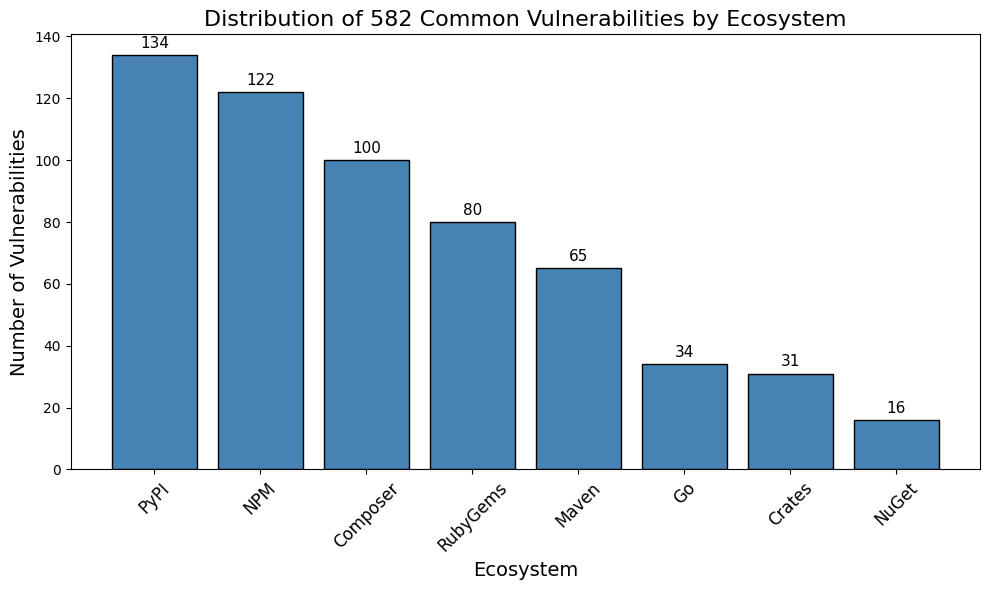


Vulnerability Count by Ecosystem:


,Vuln Count,Percentage
Ecosystem,,
Composer,100,17.2%
Crates,31,5.3%
Go,34,5.8%
Maven,65,11.2%
NPM,122,21.0%
NuGet,16,2.7%
PyPI,134,23.0%
RubyGems,80,13.7%


In [13]:
# Ecosystem vulnerability counts
ecosystem_counts = common_meta['ecosystem_counts']
ecosystems = sorted(ecosystem_counts.keys())

# Create DataFrame
eco_df = pd.DataFrame([
    {'Ecosystem': eco, 'Vuln Count': ecosystem_counts[eco], 
     'Percentage': f"{ecosystem_counts[eco]/common_meta['total_count']*100:.1f}%"}
    for eco in ecosystems
])
eco_df = eco_df.set_index('Ecosystem')

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ecosystems_sorted = sorted(ecosystem_counts.keys(), key=lambda x: ecosystem_counts[x], reverse=True)
counts_sorted = [ecosystem_counts[eco] for eco in ecosystems_sorted]

bars = ax.bar(ecosystems_sorted, counts_sorted, color='steelblue', edgecolor='black')
ax.set_xlabel('Ecosystem', fontsize=14)
ax.set_ylabel('Number of Vulnerabilities', fontsize=14)
ax.set_title(f'Distribution of {common_meta["total_count"]} Common Vulnerabilities by Ecosystem', fontsize=16)
ax.tick_params(axis='x', rotation=45, labelsize=12)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

print("\nVulnerability Count by Ecosystem:")
eco_df


## Overall Model Performance

Metrics across all ecosystems for each model on the 582 common vulnerabilities.


In [14]:
# Calculate overall metrics for each model
overall_metrics = []

for model in complete_models:
    vuln_results = all_results.get((model, 'vulnerable'), [])
    patch_results = all_results.get((model, 'patched'), [])
    metrics = calculate_metrics(vuln_results, patch_results)
    
    overall_metrics.append({
        'Model': model,
        'TP': metrics['TP'], 'FP': metrics['FP'], 'TN': metrics['TN'], 'FN': metrics['FN'],
        'Errors': metrics['Total_Errors'],
        'Precision': f"{metrics['Precision']*100:.1f}%",
        'Recall': f"{metrics['Recall']*100:.1f}%",
        'F1': f"{metrics['F1']*100:.1f}%",
        'Accuracy': f"{metrics['Accuracy']*100:.1f}%",
        'Valid': metrics['Total_Valid'],
        'Total': metrics['Vulnerable_Total'] + metrics['Patched_Total']
    })

df_overall = pd.DataFrame(overall_metrics)
df_overall = df_overall.set_index('Model')
print(f"Overall Model Performance on {common_meta['total_count']} Common Vulnerabilities")
print("="*80)
print("TP = Correctly detected vulnerable '+' code")
print("FP = Wrongly flagged safe '-' code as vulnerable")
print("TN = Correctly detected safe '-' code")
print("FN = Missed vulnerability in '+' code")
print("="*80)
df_overall


Overall Model Performance on 582 Common Vulnerabilities
TP = Correctly detected vulnerable '+' code
FP = Wrongly flagged safe '-' code as vulnerable
TN = Correctly detected safe '-' code
FN = Missed vulnerability in '+' code


,TP,FP,TN,FN,Errors,Precision,Recall,F1,Accuracy,Valid,Total
Model,,,,,,,,,,,
codegemma:7b,328,489,93,224,30,40.1%,59.4%,47.9%,37.1%,1134,1164
deepseek-coder-v2:16b,217,238,344,365,0,47.7%,37.3%,41.9%,48.2%,1164,1164
deepseek-r1:70b,382,332,250,200,0,53.5%,65.6%,59.0%,54.3%,1164,1164
gpt-4o,384,338,213,167,62,53.2%,69.7%,60.3%,54.2%,1102,1164
gpt-5.1,341,193,360,211,59,63.9%,61.8%,62.8%,63.4%,1105,1164
llama2:70b,472,558,22,84,28,45.8%,84.9%,59.5%,43.5%,1136,1164
llama3.3,200,301,281,382,0,39.9%,34.4%,36.9%,41.3%,1164,1164
mixtral:8x7b,64,7,574,518,1,90.1%,11.0%,19.6%,54.9%,1163,1164
phi3:14b,189,170,390,364,49,52.6%,34.2%,41.4%,52.0%,1113,1164


## Metrics by Ecosystem

Cell format: Recall / Precision / Accuracy (%) / Valid samples


In [15]:
# Build the metrics table by ecosystem
table_data = []

for ecosystem in ecosystems:
    row = {'Ecosystem': ecosystem, 'Vulns': ecosystem_counts[ecosystem]}
    
    for model in complete_models:
        vuln_results = [r for r in all_results.get((model, 'vulnerable'), []) if r.get('platform') == ecosystem]
        patch_results = [r for r in all_results.get((model, 'patched'), []) if r.get('platform') == ecosystem]
        
        if vuln_results or patch_results:
            metrics = calculate_metrics(vuln_results, patch_results)
            valid = metrics['Total_Valid']
            errors = metrics['Total_Errors']
            if valid > 0:
                cell = f"{metrics['Recall']*100:.0f}/{metrics['Precision']*100:.0f}/{metrics['Accuracy']*100:.0f}"
                if errors > 0:
                    cell += f"(+{errors}e)"
            else:
                cell = f"-/{errors}err"
        else:
            cell = "-"
        row[model] = cell
    table_data.append(row)

# Add overall row
overall_row = {'Ecosystem': 'OVERALL', 'Vulns': common_meta['total_count']}
for model in complete_models:
    metrics = calculate_metrics(all_results.get((model, 'vulnerable'), []), all_results.get((model, 'patched'), []))
    cell = f"{metrics['Recall']*100:.0f}/{metrics['Precision']*100:.0f}/{metrics['Accuracy']*100:.0f}"
    if metrics['Total_Errors'] > 0:
        cell += f"(+{metrics['Total_Errors']}e)"
    overall_row[model] = cell
table_data.append(overall_row)

df_ecosystem = pd.DataFrame(table_data)
df_ecosystem = df_ecosystem.set_index('Ecosystem')
print("Cell format: Recall / Precision / Accuracy (%) [+errors if any]")
df_ecosystem


Cell format: Recall / Precision / Accuracy (%) [+errors if any]


,Vulns,codegemma:7b,deepseek-coder-v2:16b,deepseek-r1:70b,gpt-4o,gpt-5.1,llama2:70b,llama3.3,mixtral:8x7b,phi3:14b,qwen2.5-coder:32b
Ecosystem,,,,,,,,,,,
Composer,100,59/38/34(+9e),35/47/48,74/55/56,73/47/46(+24e),69/57/59(+24e),84/46/43(+5e),43/46/46,11/85/55,24/39/43(+7e),61/50/50
Crates,31,71/44/40,35/50/50,65/49/48,84/65/69,74/77/76,87/46/43(+1e),26/38/42,6/100/53,30/41/44(+1e),55/57/56
Go,34,61/41/40(+3e),53/53/53,68/48/47,55/60/59(+2e),55/56/56(+2e),87/45/43(+3e),12/27/40,18/100/59,35/69/60(+6e),12/33/44
Maven,65,43/38/37(+2e),29/51/51,58/50/50,72/59/61(+2e),62/69/67(+2e),90/48/48(+4e),23/33/38,25/94/62,46/61/58(+13e),35/46/47
NPM,122,62/42/39(+2e),45/47/48,71/59/61,68/51/51(+18e),63/66/65(+14e),85/46/44(+3e),42/44/44,10/80/54,42/54/53(+12e),50/49/49
NuGet,16,81/48/47,25/67/56,56/56/56,67/62/63(+2e),67/100/83(+2e),94/48/47,25/31/34,6/100/53,40/46/48(+1e),44/54/53
PyPI,134,57/40/37(+8e),40/45/46,62/53/53,65/54/55(+10e),59/66/65(+11e),76/43/40(+11e),35/40/41,8/100/54,27/52/52(+7e),43/46/46
RubyGems,80,62/39/34(+6e),28/47/48,60/52/52,76/51/51(+4e),53/56/56(+4e),92/48/47(+1e),35/36/36,6/83/52(+1e),39/61/58(+2e),42/45/45
OVERALL,582,59/40/37(+30e),37/48/48,66/54/54,70/53/54(+62e),62/64/63(+59e),85/46/43(+28e),34/40/41,11/90/55(+1e),34/53/52(+49e),45/48/48


## Visualization


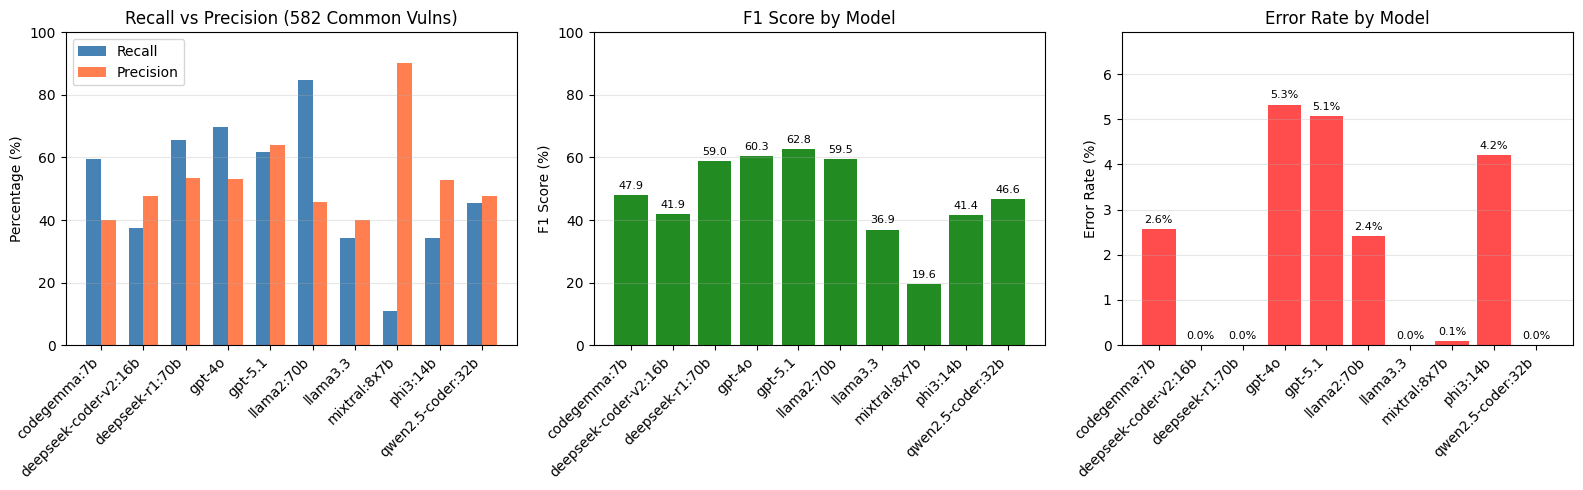

In [16]:
# Collect metrics for plotting
models = []
recalls = []
precisions = []
f1s = []
error_rates = []

for model in complete_models:
    vuln_results = all_results.get((model, 'vulnerable'), [])
    patch_results = all_results.get((model, 'patched'), [])
    metrics = calculate_metrics(vuln_results, patch_results)
    if metrics['Total_Valid'] > 0:
        models.append(model)
        recalls.append(metrics['Recall'] * 100)
        precisions.append(metrics['Precision'] * 100)
        f1s.append(metrics['F1'] * 100)
        total = metrics['Vulnerable_Total'] + metrics['Patched_Total']
        error_rates.append(metrics['Total_Errors'] / total * 100 if total > 0 else 0)

# Bar charts
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
x = range(len(models))
width = 0.35

# Recall vs Precision
ax1 = axes[0]
ax1.bar([i - width/2 for i in x], recalls, width, label='Recall', color='steelblue')
ax1.bar([i + width/2 for i in x], precisions, width, label='Precision', color='coral')
ax1.set_ylabel('Percentage (%)')
ax1.set_title(f'Recall vs Precision ({common_meta["total_count"]} Common Vulns)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# F1 Score
ax2 = axes[1]
bars = ax2.bar(x, f1s, color='forestgreen')
ax2.set_ylabel('F1 Score (%)')
ax2.set_title('F1 Score by Model')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Error Rate
ax3 = axes[2]
bars = ax3.bar(x, error_rates, color='red', alpha=0.7)
ax3.set_ylabel('Error Rate (%)')
ax3.set_title('Error Rate by Model')
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.set_ylim(0, max(error_rates) * 1.3 if max(error_rates) > 0 else 10)
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


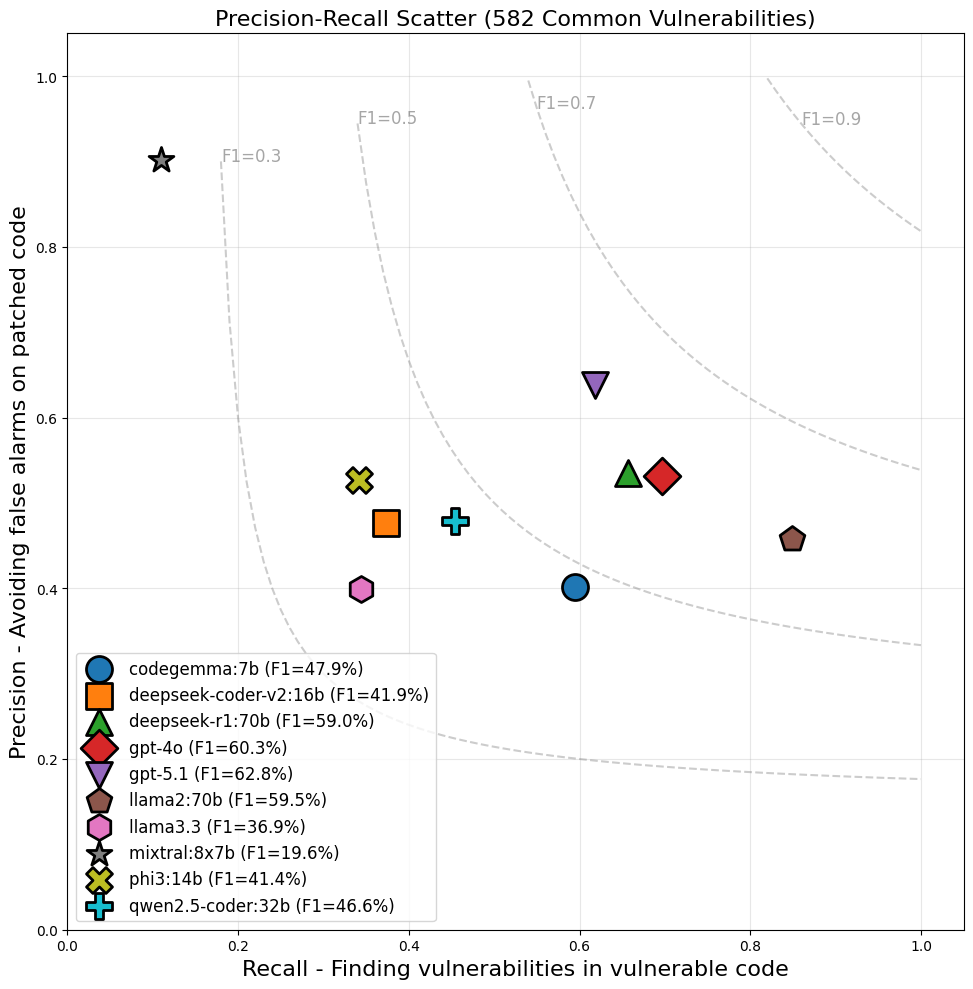

In [17]:
# Precision-Recall Scatter Plot
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
markers = ['o', 's', '^', 'D', 'v', 'p', 'h', '*', 'X', 'P']

for i, model in enumerate(models):
    recall_val = recalls[i] / 100
    precision_val = precisions[i] / 100
    f1_val = f1s[i] / 100
    ax.scatter(recall_val, precision_val, 
               s=350, c=[colors[i]], marker=markers[i % len(markers)],
               label=f"{model} (F1={f1_val*100:.1f}%)", 
               edgecolors='black', linewidths=2, zorder=5)

# Add F1 iso-curves
for f1_target in [0.3, 0.5, 0.7, 0.9]:
    recall_range = np.linspace(0.01, 1.0, 100)
    precision_vals = (f1_target * recall_range) / (2 * recall_range - f1_target)
    valid = (precision_vals >= 0) & (precision_vals <= 1)
    ax.plot(recall_range[valid], precision_vals[valid], '--', color='gray', alpha=0.4, linewidth=1.5)
    idx = np.argmin(np.abs(precision_vals - 0.95))
    if valid[idx]:
        ax.annotate(f'F1={f1_target}', (recall_range[idx], precision_vals[idx]), fontsize=12, color='gray', alpha=0.7)

ax.set_xlabel('Recall - Finding vulnerabilities in vulnerable code', fontsize=16)
ax.set_ylabel('Precision - Avoiding false alarms on patched code', fontsize=16)
ax.set_title(f'Precision-Recall Scatter ({common_meta["total_count"]} Common Vulnerabilities)', fontsize=16)
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.legend(loc='lower left', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('precision_recall_scatter.png', dpi=300)
plt.show()


## Time and Token Cost Analysis

Analysis of inference time and token usage for each model on the common vulnerabilities.


In [19]:
# Model pricing (per 1M tokens) - Update these as needed
# Format: {model_name: (input_price_per_1M, output_price_per_1M)}
MODEL_PRICING = {
    # OpenAI
    'gpt-4o': (2.50, 10.00),
    'gpt-4o-mini': (0.15, 0.60),
    'gpt-5.1': (2.00, 8.00),
    # Local/Ollama (free - running locally)
    'llama2:70b': (0.0, 0.0),
    'llama3.3': (0.0, 0.0),
    'deepseek-r1:70b': (0.0, 0.0),
    'deepseek-coder-v2:16b': (0.0, 0.0),
    'codegemma:7b': (0.0, 0.0),
    'mixtral:8x7b': (0.0, 0.0),
    'phi3:14b': (0.0, 0.0),
    'qwen2.5-coder:32b': (0.0, 0.0),
}

def calculate_cost(model_name, input_tokens, output_tokens):
    """Calculate cost for a given model and token counts."""
    pricing = MODEL_PRICING.get(model_name, (0.0, 0.0))
    input_cost = (input_tokens / 1_000_000) * pricing[0]
    output_cost = (output_tokens / 1_000_000) * pricing[1]
    return input_cost + output_cost

# Calculate time and token metrics per model
cost_data = []

for model in complete_models:
    vuln_results = all_results.get((model, 'vulnerable'), [])
    patch_results = all_results.get((model, 'patched'), [])
    all_model_results = vuln_results + patch_results
    
    total_input_tokens = 0
    total_output_tokens = 0
    total_time_seconds = 0
    count = 0
    
    for result in all_model_results:
        diff_analysis = result.get('diff_analysis', {})
        token_usage = diff_analysis.get('token_usage', {})
        
        if token_usage:
            total_input_tokens += token_usage.get('input_tokens', 0)
            total_output_tokens += token_usage.get('output_tokens', 0)
        
        analysis_time = diff_analysis.get('analysis_time_seconds', 0)
        if analysis_time:
            total_time_seconds += analysis_time
            count += 1
    
    total_tokens = total_input_tokens + total_output_tokens
    total_cost = calculate_cost(model, total_input_tokens, total_output_tokens)
    avg_time = total_time_seconds / count if count > 0 else 0
    
    cost_data.append({
        'Model': model,
        'Input Tokens': total_input_tokens,
        'Output Tokens': total_output_tokens,
        'Total Tokens': total_tokens,
        'Total Cost ($)': total_cost,
        'Avg Time (s)': avg_time,
        'Analyses': len(all_model_results)
    })

cost_df = pd.DataFrame(cost_data)
cost_df = cost_df.set_index('Model')

print("="*80)
print(f"TOKEN USAGE AND INFERENCE TIME ({common_meta['total_count']} Common Vulnerabilities)")
print("="*80)
print()
cost_df


TOKEN USAGE AND INFERENCE TIME (582 Common Vulnerabilities)



,Input Tokens,Output Tokens,Total Tokens,Total Cost ($),Avg Time (s),Analyses
Model,,,,,,
codegemma:7b,5803212,100834,5904046,0.000000,1.681306,1164
deepseek-coder-v2:16b,13716422,51257,13767679,0.000000,4.464081,1164
deepseek-r1:70b,12360880,962221,13323101,0.000000,49.895558,1164
gpt-4o,12797287,57041,12854328,32.563628,2.391151,1164
gpt-5.1,13548119,120396,13668515,28.059406,2.495524,1164
llama2:70b,3634176,130522,3764698,0.000000,6.812792,1164
llama3.3,12373143,46736,12419879,0.000000,9.552517,1164
mixtral:8x7b,14156352,57701,14214053,0.000000,2.515275,1164
phi3:14b,14196238,99706,14295944,0.000000,4.297509,1164


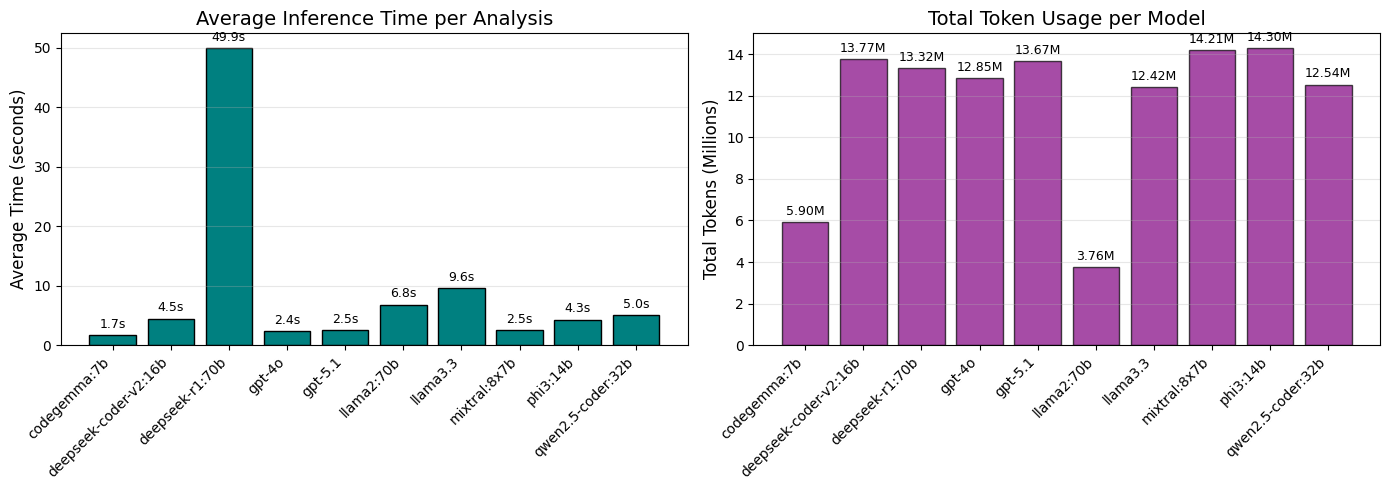


SUMMARY STATISTICS
Total analyses per model: 1164 (582 vuln + 582 patched)

Fastest model: codegemma:7b (1.68s avg)
Slowest model: deepseek-r1:70b (49.90s avg)

Least tokens: llama2:70b (3.76M)
Most tokens: phi3:14b (14.30M)


In [20]:
# Visualize time and token usage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = cost_df.index.tolist()
x = range(len(model_names))

# Average inference time
ax1 = axes[0]
times = [cost_df.loc[m, 'Avg Time (s)'] for m in model_names]
bars1 = ax1.bar(x, times, color='teal', edgecolor='black')
ax1.set_ylabel('Average Time (seconds)', fontsize=12)
ax1.set_title('Average Inference Time per Analysis', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}s', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Total tokens (in millions)
ax2 = axes[1]
tokens_m = [cost_df.loc[m, 'Total Tokens'] / 1_000_000 for m in model_names]
bars2 = ax2.bar(x, tokens_m, color='purple', alpha=0.7, edgecolor='black')
ax2.set_ylabel('Total Tokens (Millions)', fontsize=12)
ax2.set_title('Total Token Usage per Model', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}M', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total analyses per model: {cost_df['Analyses'].iloc[0]} (582 vuln + 582 patched)")
print(f"\nFastest model: {model_names[np.argmin(times)]} ({min(times):.2f}s avg)")
print(f"Slowest model: {model_names[np.argmax(times)]} ({max(times):.2f}s avg)")
print(f"\nLeast tokens: {model_names[np.argmin(tokens_m)]} ({min(tokens_m):.2f}M)")
print(f"Most tokens: {model_names[np.argmax(tokens_m)]} ({max(tokens_m):.2f}M)")
